# Filling a circle with rectangles 
### Task description:
Solve a variant of the problem known in the literature as the cutting stock problem.

We have a given circle of radius r and a set of available rectangles given by three numbers: height, width and value.

The goal is to arrange the rectangles in the circle so as to maximize the sum of their values, satisfying the following conditions:
* the sides of all rectangles were parallel to the axis of the system,
* the interiors of the rectangles had no parts in common (intuitively: the rectangles do not overlap, but they can touch each other with their sides),
* each rectangle can be inserted any number of times.

Propose an encoding of the problem, a mutation and crossover operator, and implement a genetic algorithm to solve the above problem.

### My solution: 
**Initialization**: I initialize the circles with rectangles of the same type, which are arranged side by side, starting from the center of the circle.

**Crossover**: I draw 2 individuals (circles), the crossover point and the direction (vertical or horizontal). If for instance a vertical crossover is drawn, then on the right side of the division will be rectangles from one parent individual, and on the left from the other. Such crossover causes large free spaces between the left and right rectangles. In order to fill it there is implemented a mutation, which involves checking how large the distance between the 2 sets of rectangles. If it is larger than the height/width of the smallest rectangle available for a given circle radius then the gap is filled with the largest rectangles that will fit there.

**Mutation**: It involves moving the rectangles that are on the right/left/up/down from some horizontal or vertical line. Both the direction of this line and its value are chosen at random. The rectangles are shifted by a random value from the interval [1, 60].

**Selection**: The selection of individuals for the next iteration will be chosen by a tournament method from among the individuals that were created in the current iteration, i.e., both 'descendants' and and individuals after mutation.

**Stop condition**: After each iteration, the value of the best individual will be checked. If after 100 iterations this value will not improve then the algorithm will be stopped.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from copy import deepcopy, copy
import itertools
import random
random.seed(777)

In [2]:
class Rectangle:

    def __init__(self, top_right_x, top_right_y, rectangle_type=[0, 0, 0]):
        self.width = rectangle_type[0]
        self.height = rectangle_type[1]
        self.value = rectangle_type[2]
        self.top_right_x = top_right_x
        self.top_right_y = top_right_y
        self.bottom_left_x = self.top_right_x - self.width 
        self.bottom_left_y = self.top_right_y - self.height

    def intersects(self, other):
        return not (self.top_right_x < other.bottom_left_x or self.bottom_left_x > other.top_right_x or self.top_right_y < other.bottom_left_y or self.bottom_left_y > other.top_right_y)

    def is_in_circle(self, radius):
        if (self.top_right_x)**2 + (self.top_right_y)**2 > radius**2: #1st quarter
            return False
        if (self.bottom_left_x)**2 + (self.top_right_y)**2 > radius**2: #2nd quarter
            return False
        if (self.bottom_left_x)**2 + (self.bottom_left_y)**2 > radius**2: #3rd quarter
            return False
        if (self.top_right_x)**2 + (self.bottom_left_y)**2 > radius**2: #4th quarter
            return False
        return True 

In [3]:
class CircleWithRectangles:

    def __init__(self, rectangles_list, radius):
        self.rectangles_list = rectangles_list
        self.score = 0
        self.radius = radius
    
    def calculate_score(self):
        self.score = sum(rectangle.value for rectangle in self.rectangles_list)

    def remove_not_in_circle(self):
        to_remove = []
        for rectangle in self.rectangles_list:
            if not rectangle.is_in_circle(self.radius):
                to_remove.append(rectangle)
        self.rectangles_list = [x for x in self.rectangles_list if x not in to_remove]
    
    def remove_intersects(self):
        to_remove = []
        for rect1, rect2 in itertools.combinations(self.rectangles_list, 2):
            if rect1.intersects(rect2):
                if rect1.value >= rect2.value:
                    to_remove.append(rect2)
                else:
                    to_remove.append(rect1)
        self.rectangles_list = [x for x in self.rectangles_list if x not in to_remove]    
    
    def plot_circle(self):
        circle = plt.Circle((0, 0), self.radius, color='#4d004d', fill=False)
        fig, ax = plt.subplots()

        plt.xlim(-self.radius, self.radius)
        plt.ylim(-self.radius, self.radius)
        ax.tick_params(axis='both', which='both', labelbottom=False, bottom=False, left=False, labelleft=False)
        ax.set_aspect(1)
        ax.add_artist(circle)

        for rect in self.rectangles_list:
            rectangle = patches.Rectangle((rect.bottom_left_x, rect.bottom_left_y), rect.width, rect.height, linewidth=1, edgecolor='#4d004d', facecolor='#e6ccff', alpha=0.5)
            ax.add_patch(rectangle)
        plt.show()  

In [4]:
def get_rectangles_types(radius):
    rectangles = pd.read_csv('./../data/cutting/r'+str(radius)+'.csv', header=None)
    rectangles.columns = ['width', 'height', 'value']
    rectangles_rotated = rectangles.copy()
    rectangles_rotated.columns = ['height', 'width', 'value']
    all_rectangles_types = pd.concat([rectangles, rectangles_rotated])
    all_rectangles_types.loc[(all_rectangles_types.value / (all_rectangles_types.width * all_rectangles_types.height)).sort_values(ascending=False).index]
    all_rectangles_types.reset_index(drop=True, inplace=True)
    return all_rectangles_types

## Initialization

In [5]:
def initialize_circle_with_rectangles(rectangle_type, radius):
    rectangles_list = []
    width = rectangle_type[0]
    height = rectangle_type[1]

    x_n = radius//width
    y_n = radius//height

    for y in range(-y_n+1, y_n+1):
        for x in range(1, x_n+1): 
            rectangle_right = Rectangle(x*width, y*height, rectangle_type)
            rectangle_left = Rectangle(-(x-1)*width, y*height, rectangle_type)
            if rectangle_right.is_in_circle(radius):
                rectangles_list.append(rectangle_right)
                rectangles_list.append(rectangle_left)
            else:
                break
    
    return CircleWithRectangles(rectangles_list, radius)

In [6]:
def initialize_population(rectangles_types, radius):
    population = []
    for i in range(len(rectangles_types)):
        population.append(initialize_circle_with_rectangles(rectangles_types.loc[i, :].values.tolist(), radius)) 
    return population

## Stop condition

In [7]:
def early_stopping(best_circle, population, epochs_without_improvement):
    best_circle_new = max(population, key=attrgetter('score'))
    if best_circle_new.score > best_circle.score:
        best_circle = best_circle_new
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    return epochs_without_improvement, best_circle

## Crossover with mutation

In [8]:
def crossover(population, crossover_ratio, radius, rectangles_types):

    offsprings = []
    for i in range(int(crossover_ratio*len(population))):
        circle_ix = random.sample(range(0, len(population)), 2)
        circle_1 = population[circle_ix[0]]
        circle_2 = population[circle_ix[1]]
        new_offspring = single_crossover(circle_1, circle_2, radius, rectangles_types)
        offsprings.append(new_offspring)

    return offsprings

In [9]:
def single_crossover(circle_1, circle_2, radius, rectangles_types):

    circle_1_rect = circle_1.rectangles_list
    circle_2_rect = circle_2.rectangles_list
    crossover_point = random.randrange(-radius+500, radius-500, 10) # 500 to make a difference
    is_vertical = bool(random.getrandbits(1))
    if is_vertical:
        offsprings_rectangles = [rectangle for rectangle in circle_1_rect if rectangle.top_right_x < crossover_point]
        offsprings_rectangles.extend([rectangle for rectangle in circle_2_rect if rectangle.bottom_left_x >= crossover_point])
        offsprings_rectangles.extend(fill_space_after_crossover(circle_1, circle_2, is_vertical, crossover_point, radius, rectangles_types))
    else:
        offsprings_rectangles = [rectangle for rectangle in circle_1_rect if rectangle.top_right_y < crossover_point]
        offsprings_rectangles.extend([rectangle for rectangle in circle_2_rect if rectangle.bottom_left_y >= crossover_point])
        offsprings_rectangles.extend(fill_space_after_crossover(circle_1, circle_2, is_vertical, crossover_point, radius, rectangles_types))
    
    return CircleWithRectangles(offsprings_rectangles, radius, circle_1, circle_2)

In [10]:
def fill_space_after_crossover(circle_1, circle_2, is_vertical, crossover_point, radius, rectangles_types):

    circle_1_rect = circle_1.rectangles_list
    circle_2_rect = circle_2.rectangles_list
    rectangles_to_fill = []
    if is_vertical:
        if [rectangle.top_right_x for rectangle in circle_1_rect if rectangle.top_right_x < crossover_point] and [rectangle.bottom_left_x for rectangle in circle_2_rect if rectangle.bottom_left_x >= crossover_point]:
            max_right_x = max(rectangle.top_right_x for rectangle in circle_1_rect if rectangle.top_right_x < crossover_point)
            min_left_x = min(rectangle.bottom_left_x for rectangle in circle_2_rect if rectangle.bottom_left_x >= crossover_point)
            min_width_in_set = rectangles_types.loc[rectangles_types['width'].idxmin(), :].values.tolist()[0]

            if min_width_in_set <= min_left_x - max_right_x:
                max_width_that_fits = max(rectangles_types.loc[rectangles_types['width'] <= min_left_x - max_right_x,  'width'])
                if min_left_x - max_right_x >= max_width_that_fits:
                    min_rect_type = rectangles_types.loc[rectangles_types['width'] == max_width_that_fits].head(1).iloc[0]
                    height = min_rect_type[1]
                    y_n = radius//height
                    for y in range(-y_n, y_n+1):
                        rectangle_to_fill = Rectangle(min_left_x, y*height, min_rect_type)
                        if rectangle_to_fill.is_in_circle(radius):
                            rectangles_to_fill.append(rectangle_to_fill)
    else:
        if [rectangle.top_right_y for rectangle in circle_1_rect if rectangle.top_right_y < crossover_point] and [rectangle.bottom_left_y for rectangle in circle_2_rect if rectangle.bottom_left_y >= crossover_point]:
            max_top_y = max(rectangle.top_right_y for rectangle in circle_1_rect if rectangle.top_right_y < crossover_point)
            min_bottom_y = min(rectangle.bottom_left_y for rectangle in circle_2_rect if rectangle.bottom_left_y >= crossover_point)
            min_height_in_set = rectangles_types.loc[rectangles_types['height'].idxmin(), :].values.tolist()[1]

            if min_height_in_set <= min_bottom_y - max_top_y:
                max_height_that_fits = max(rectangles_types.loc[rectangles_types['height'] <= min_bottom_y - max_top_y,  'height'])
                if min_bottom_y - max_top_y >= max_height_that_fits:
                    min_rect_type = rectangles_types.loc[rectangles_types['height'] == max_height_that_fits].head(1).iloc[0].values.tolist()
                    width = min_rect_type[0]
                    x_n = radius//width
                    for x in range(-x_n, x_n+1):
                        rectangle_to_fill = Rectangle(x*width, min_bottom_y, min_rect_type)
                        if rectangle_to_fill.is_in_circle(radius):
                            rectangles_to_fill.append(rectangle_to_fill)
                        
    return rectangles_to_fill

## Mutation

In [11]:
def mutate(population, mutation_ratio, radius):

    mutated_circles = []
    for i in range(int(mutation_ratio*len(population))):
        circle_ix = random.randint(0, len(population)-1)
        circle_to_mutate = population[circle_ix]
        mutated_circle = single_mutation(circle_to_mutate, radius)
        #mutated_circle.remove_not_in_circle()
        #mutated_circle.remove_intersects() 
        mutated_circles.append(mutated_circle)
    
    return mutated_circles

In [12]:
def single_mutation(circle_to_mutate, radius): 
    circle_rectangles = []

    for rectangle in circle_to_mutate.rectangles_list:
        circle_rectangles.append(Rectangle(rectangle.top_right_x, rectangle.top_right_y, [rectangle.width, rectangle.height, rectangle.value]))
    
    mutation_point = random.randrange(-radius+500, radius-500, 10) # 500 to make a difference
    mutation_direction = random.choice(['top', 'bottom', 'right', 'left'])
    shift = random.randrange(1, 61)
    if mutation_direction == 'top':
        mutated_part = [rectangle for rectangle in circle_rectangles if rectangle.bottom_left_y > mutation_point]
        postmutation_rectangles = [rectangle for rectangle in circle_rectangles if rectangle.top_right_y <= mutation_point + shift] # part without changes
        for rectangle in mutated_part:
            rectangle.top_right_y += shift
            rectangle.bottom_left_y += shift
            if rectangle.is_in_circle(radius):
                postmutation_rectangles.append(rectangle)
    elif mutation_direction == 'bottom':
        mutated_part = [rectangle for rectangle in circle_rectangles if rectangle.top_right_y < mutation_point]
        postmutation_rectangles = [rectangle for rectangle in circle_rectangles if rectangle.bottom_left_y >= mutation_point - shift] # part without changes
        for rectangle in mutated_part:
            rectangle.top_right_y -= shift
            rectangle.bottom_left_y -= shift
            if rectangle.is_in_circle(radius):
                postmutation_rectangles.append(rectangle)
    elif mutation_direction == 'right':
        mutated_part = [rectangle for rectangle in circle_rectangles if rectangle.bottom_left_x > mutation_point]
        postmutation_rectangles = [rectangle for rectangle in circle_rectangles if rectangle.top_right_x <= mutation_point + shift] # part without changes
        for rectangle in mutated_part:
            rectangle.top_right_x += shift
            rectangle.bottom_left_x += shift
            if rectangle.is_in_circle(radius):
                postmutation_rectangles.append(rectangle)
    else:
        mutated_part = [rectangle for rectangle in circle_rectangles if rectangle.top_right_x < mutation_point]
        postmutation_rectangles = [rectangle for rectangle in circle_rectangles if rectangle.bottom_left_x >= mutation_point - shift] # part without changes
        for rectangle in mutated_part:
            rectangle.top_right_x -= shift
            rectangle.bottom_left_x -= shift
            if rectangle.is_in_circle(radius):
                postmutation_rectangles.append(rectangle)

    circle_mutated = CircleWithRectangles(postmutation_rectangles, radius, premutated=circle_to_mutate)
    return circle_mutated

## Selection

In [13]:
def tournament(circle_1, circle_2):
    if circle_1.score >= circle_2.score:
        return circle_1
    return circle_2

In [14]:
def selection(population_for_selection):
    new_population =[]
    random.shuffle(population_for_selection)
    for i in range(0, 2*(len(population_for_selection)//2), 2):
        winner = tournament(population_for_selection[i], population_for_selection[i+1])
        new_population.append(winner)
    return new_population

In [ ]:
def select_n_best()

# Genetic algorithm 

In [15]:
def genetic_algorithm(radius, epochs, crossover_ratio, mutation_ratio):

    rectangles_types = get_rectangles_types(radius)
    population = initialize_population(rectangles_types, radius)
    epochs_without_improvement = 0

    for epoch in range(epochs):
        print(epoch)
        for circle in population:
            circle.calculate_score()
        best_circle = max(population, key=attrgetter('score'))
        epochs_without_improvement, best_circle = early_stopping(best_circle, population, epochs_without_improvement)
        if epochs_without_improvement > 100:
            print('The algorithm did not improve after 5 epochs, so it was stopped at epoch {}. The best circle was saved.'.format(epoch))
            break
        offsprings = crossover(population, crossover_ratio, radius, rectangles_types)
        mutated = mutate(population, mutation_ratio, radius)
        population_for_selection = offsprings + mutated
        new_circles = selection(population_for_selection + pupulation)
        population = population + new_circles
        
    return best_circle, population

In [16]:
best = genetic_algorithm(1100, 45, 0.35, 0.25)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44


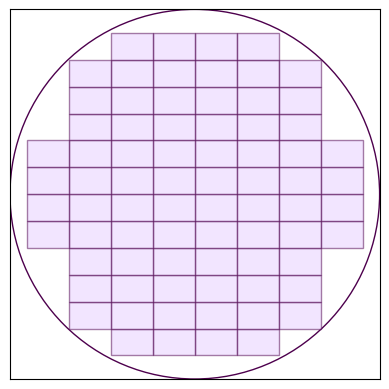

In [17]:
best.plot_circle()

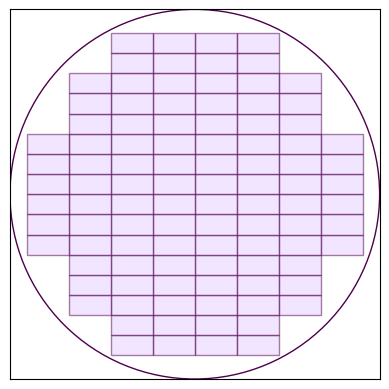

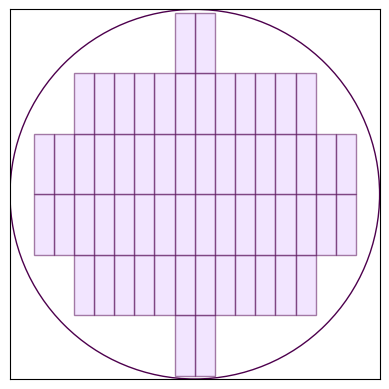

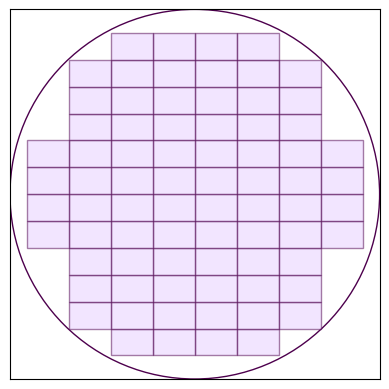

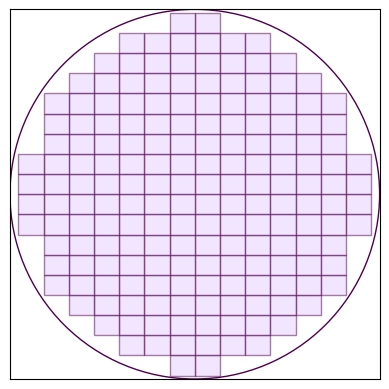

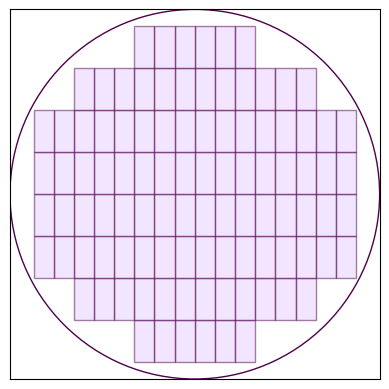

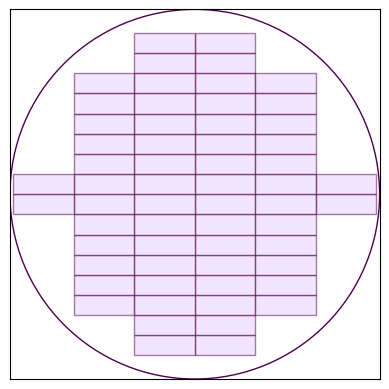

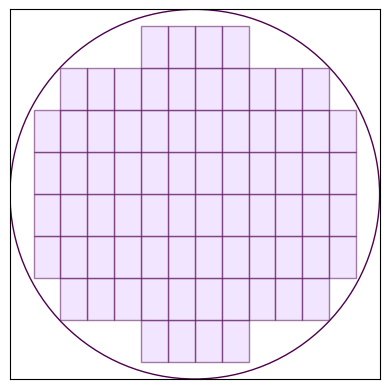

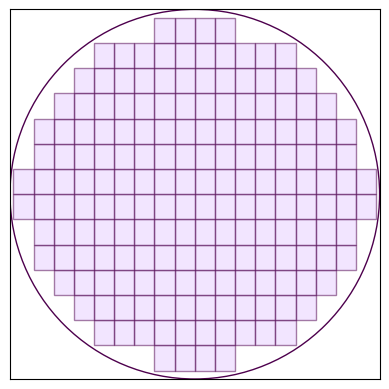

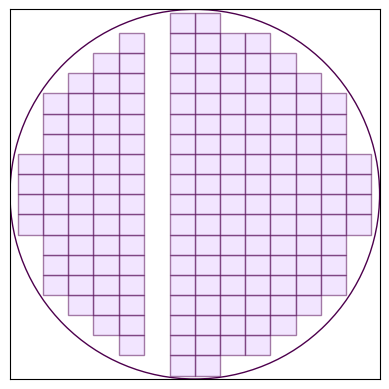

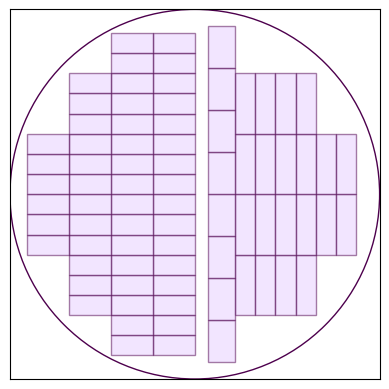

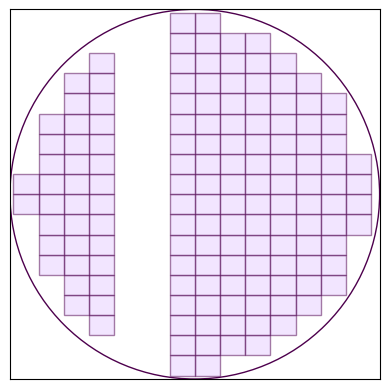

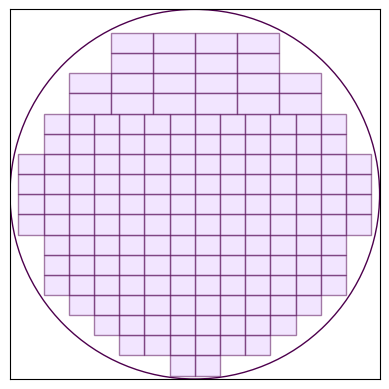

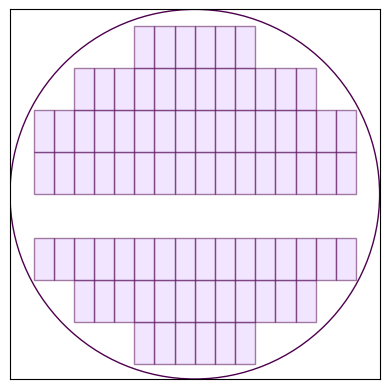

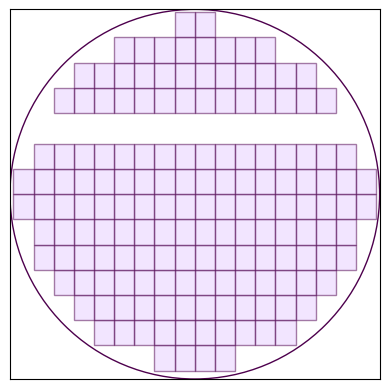

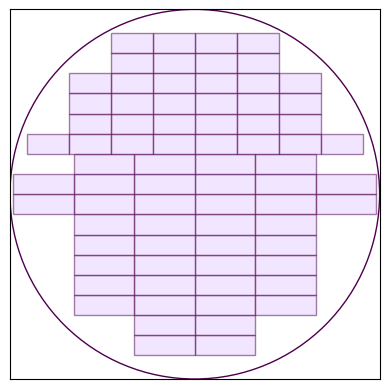

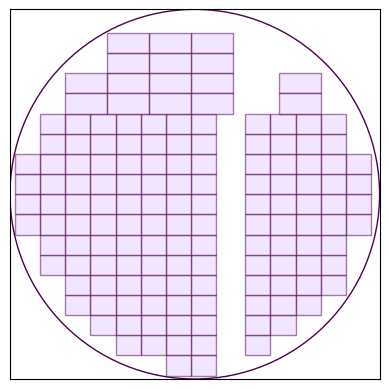

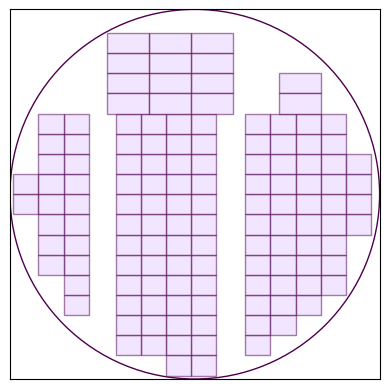

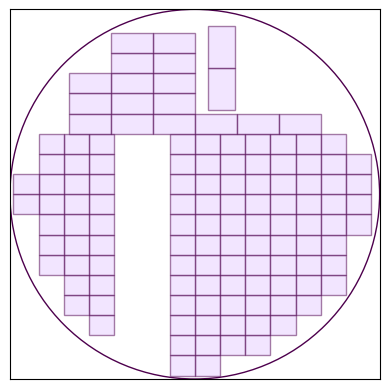

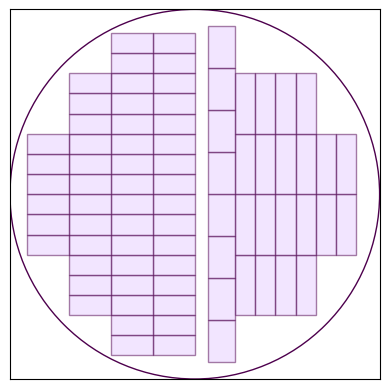

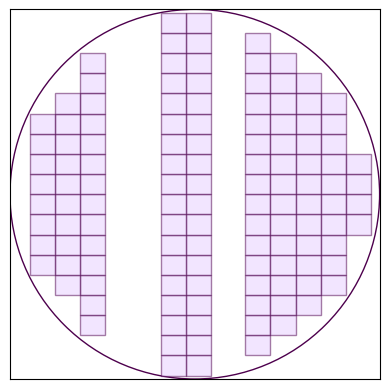

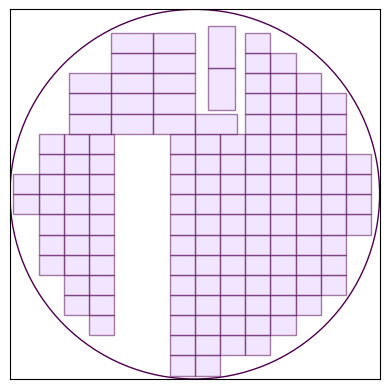

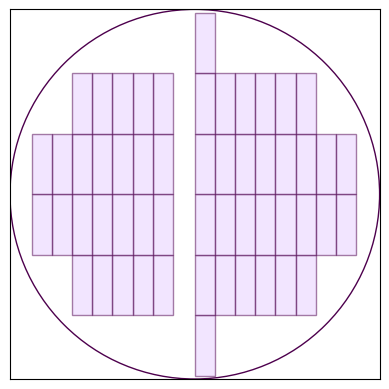

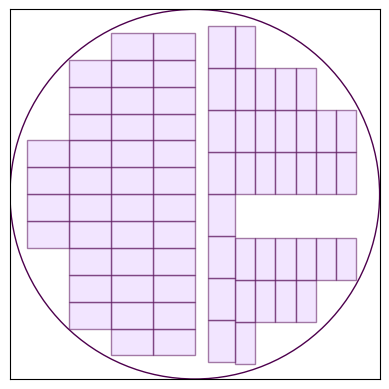

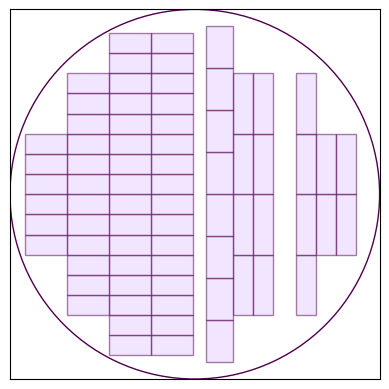

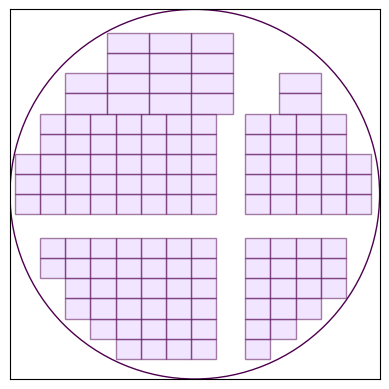

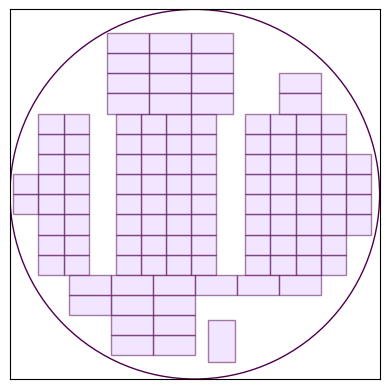

In [21]:
for circle in best:
    circle.plot_circle()

# Wyniki

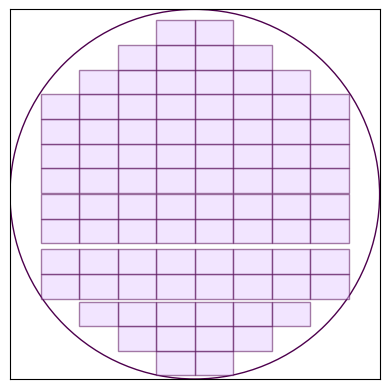

44000

In [33]:
best_1200 = genetic_algorithm(1200, 3, 0.5, 0.5)
best_1200.plot_circle()
best_1200.score

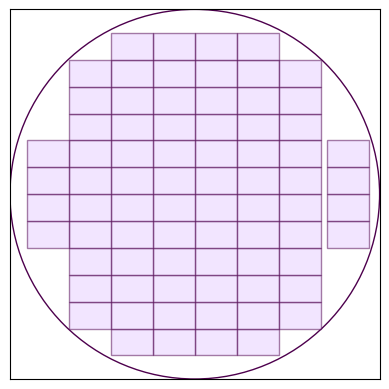

45600

In [39]:
best_1100 = genetic_algorithm(1100, 3, 0.5, 0.5)
best_1100.plot_circle()
best_1100.score

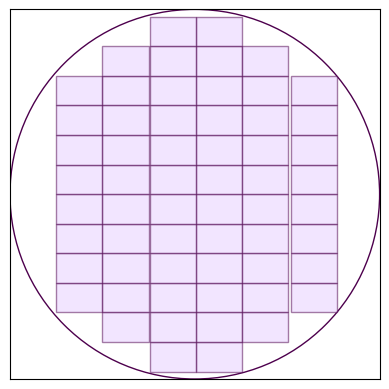

30000

In [44]:
best_1000 = genetic_algorithm(1000, 3, 0.5, 0.5)
best_1000.plot_circle()
best_1000.score

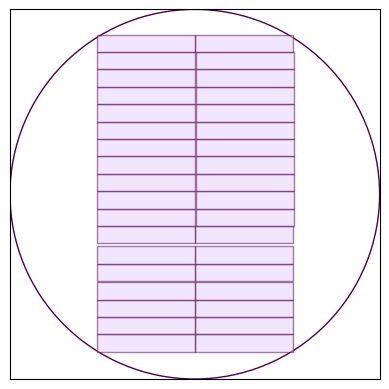

396000

In [45]:
best_850 = genetic_algorithm(850, 3, 0.5, 0.5)
best_850.plot_circle()
best_850.score

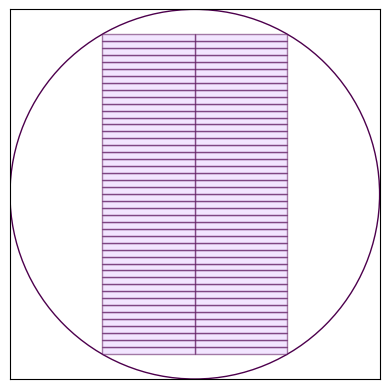

36800

In [53]:
best_800 = genetic_algorithm(800, 3, 0.5, 0.5)
best_800.plot_circle()
best_800.score